In [ ]:
# ============================
# Simplified paper replication
# Strategy-embedded loss + PBWA weighting
# Using free OHLCV from yfinance
# ============================

import os
import math
import random
import numpy as np
import pandas as pd

import yfinance as yf

import torch
import torch.nn as nn
from torch.optim import Adam

# ----------------------------
# Reproducibility
# ----------------------------
def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Universe: S&P500 tickers (free)
# ----------------------------

def load_sp500_tickers_yf():
    t = yf.Ticker("^GSPC")
    tickers = list(t.constituents.keys()) if getattr(t, "constituents", None) else None
    if not tickers:
        raise RuntimeError("yfinance constituents not available in your version.")
    return [x.replace(".", "-") for x in tickers]


# ----------------------------
# Data download (OHLCV)
# ----------------------------
def download_ohlcv(tickers, start="2010-01-01", end=None, auto_adjust=False):
    """
    Returns: dict with keys Open, High, Low, Close, Volume as DataFrames [date x ticker]
    yfinance can be flaky; download in chunks.
    """
    if end is None:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")

    chunks = []
    chunk_size = 100
    for i in range(0, len(tickers), chunk_size):
        chunks.append(tickers[i:i+chunk_size])

    frames = []
    for ch in chunks:
        data = yf.download(
            ch, start=start, end=end, auto_adjust=auto_adjust,
            group_by="column", threads=True, progress=False
        )
        # If multiple tickers, columns are MultiIndex: (field, ticker)
        if isinstance(data.columns, pd.MultiIndex):
            frames.append(data)
        else:
            # single ticker edge case
            data.columns = pd.MultiIndex.from_product([data.columns, ch])
            frames.append(data)

    data = pd.concat(frames, axis=1).sort_index()
    out = {}
    for field in ["Open", "High", "Low", "Close", "Volume"]:
        out[field] = data[field].copy()
    return out

# ----------------------------
# Features (all shifted by 1 day)
# ----------------------------
def rsi(close: pd.DataFrame, window: int = 14):
    delta = close.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    roll_up = up.rolling(window, min_periods=window).mean()
    roll_down = down.rolling(window, min_periods=window).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))

def make_features(data):
    """
    data: dict Open/Close/Volume DF
    returns: features panel (date x ticker x feature), labels (date x ticker)
    """
    close = data["Close"]
    open_ = data["Open"]
    volu = data["Volume"]

    # Label: open->close return for day t (what we trade)
    y = (close / open_) - 1.0

    # Basic returns for feature engineering (close-to-close)
    cc = close.pct_change()

    # Momentum / reversal
    mom20 = close / close.shift(20) - 1
    mom60 = close / close.shift(60) - 1
    mom252 = close / close.shift(252) - 1
    rev5 = close / close.shift(5) - 1

    # Volatility
    vol20 = cc.rolling(20, min_periods=20).std(ddof=0)

    # MA ratios
    ma20 = close.rolling(20, min_periods=20).mean()
    ma60 = close.rolling(60, min_periods=60).mean()
    prc_ma20 = close / (ma20 + 1e-12) - 1
    prc_ma60 = close / (ma60 + 1e-12) - 1

    # Volume z-score
    vma20 = volu.rolling(20, min_periods=20).mean()
    vsd20 = volu.rolling(20, min_periods=20).std(ddof=0)
    volz20 = (volu - vma20) / (vsd20 + 1e-12)

    # RSI
    rsi14 = rsi(close, 14) / 100.0  # scale to [0,1]

    feats = {
        "mom20": mom20,
        "mom60": mom60,
        "mom252": mom252,
        "rev5": rev5,
        "vol20": vol20,
        "prc_ma20": prc_ma20,
        "prc_ma60": prc_ma60,
        "volz20": volz20,
        "rsi14": rsi14,
    }

    # Shift ALL features by 1 day to ensure they're known at time of trading (today open)
    feats = {k: v.shift(1) for k, v in feats.items()}

    return feats, y

# ----------------------------
# Liquidity filter (avg dollar volume)
# ----------------------------
def liquid_universe(data, tickers, top_n=200, window=60):
    close = data["Close"][tickers]
    volu = data["Volume"][tickers]
    dolv = (close * volu).rolling(window, min_periods=window).mean()
    # Choose tickers with highest average dolv over entire sample (simple)
    score = dolv.mean().sort_values(ascending=False)
    return score.head(top_n).index.tolist()

# ----------------------------
# Build day-batches of sequences
# ----------------------------
def build_day_batches(feats_dict, y, tickers, seq_len=20, start_date=None, end_date=None):
    """
    For each date t, we create X: [n_stocks, seq_len, n_features], Y: [n_stocks]
    Sequences are constructed from shifted features, so they end at t (feature at t uses info up to t-1).
    """
    feat_names = list(feats_dict.keys())
    dates = y.index

    if start_date is not None:
        dates = dates[dates >= pd.to_datetime(start_date)]
    if end_date is not None:
        dates = dates[dates <= pd.to_datetime(end_date)]

    # Stack features into (date x ticker x feat)
    # We'll keep in pandas for alignment then convert per day.
    F = []
    for fn in feat_names:
        df = feats_dict[fn][tickers]
        F.append(df)
    # shape: list of DFs
    # We'll fetch rolling windows per ticker per day.
    # Efficient enough for ~200 tickers, ~3000 days.

    batches = []
    for t in dates:
        # Need seq_len rows ending at t
        idx_pos = y.index.get_loc(t)
        if idx_pos < seq_len:
            continue
        window_dates = y.index[idx_pos - seq_len + 1 : idx_pos + 1]

        # Build X for all tickers: [n, seq_len, f]
        X_list = []
        for fn in feat_names:
            X_list.append(feats_dict[fn].loc[window_dates, tickers].values[:, :])
        X = np.stack(X_list, axis=-1)  # [seq_len, n, f]
        X = np.transpose(X, (1, 0, 2)) # [n, seq_len, f]

        Y = y.loc[t, tickers].values  # [n]

        # Drop tickers with any NaNs in sequence or label
        mask = np.isfinite(Y)
        mask &= np.isfinite(X).all(axis=(1, 2))
        if mask.sum() < 20:
            continue

        batches.append((t, X[mask], Y[mask]))

    return batches, feat_names

# ----------------------------
# Model: LSTM -> scalar return
# ----------------------------
class LSTMAlpha(nn.Module):
    def __init__(self, n_features, hidden=32, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        # x: [batch=n_stocks, seq_len, n_features]
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # last step
        pred = self.head(last).squeeze(-1)
        return pred

# ----------------------------
# PBWA weights (PyTorch)
# ----------------------------
def pbwa_weights(pred, gamma=0.0, max_w=0.02, eps=1e-12):
    """
    pred: [n]
    returns weights [n], long-only.
    """
    raw = torch.relu(pred - gamma)
    s = raw.sum()
    if s.item() <= eps:
        # fallback: no signal -> all zeros (cash)
        return torch.zeros_like(raw)

    w = raw / (s + eps)

    # hard cap + renorm (subgrad ok)
    w = torch.clamp(w, max=max_w)
    if w.sum().item() <= eps:
        return torch.zeros_like(w)
    w = w / (w.sum() + eps)
    return w

# ----------------------------
# Long-short extension of PBWA + trade counting utilities
# ----------------------------
def pbwa_long_short_weights(
    pred,
    gamma=0.0,
    max_abs_w=0.02,
    gross_long=1.0,
    gross_short=1.0,
    eps=1e-12,
):
    """
    Long-short analogue of PBWA.

    - Long scores:  ReLU(pred - gamma)
    - Short scores: ReLU(-pred - gamma)
    - Normalize longs to sum to gross_long
    - Normalize shorts (absolute) to sum to gross_short
    - Cap per-name absolute weight to max_abs_w (applied separately to long and short sides)
    """

    raw_long  = torch.relu(pred - gamma)
    raw_short = torch.relu(-pred - gamma)

    w_long = torch.zeros_like(pred)
    w_short = torch.zeros_like(pred)

    sL = raw_long.sum()
    sS = raw_short.sum()

    if sL.item() > eps:
        w_long = gross_long * (raw_long / (sL + eps))
    if sS.item() > eps:
        w_short = gross_short * (raw_short / (sS + eps))

    w = w_long - w_short

    # Apply per-name cap (separately) then renormalize each side to maintain gross exposures
    pos = torch.clamp(w, min=0.0)
    neg = torch.clamp(-w, min=0.0)  # magnitudes

    pos = torch.clamp(pos, max=max_abs_w)
    neg = torch.clamp(neg, max=max_abs_w)

    pos_sum = pos.sum()
    neg_sum = neg.sum()

    if pos_sum.item() > eps:
        pos = gross_long * (pos / (pos_sum + eps))
    else:
        pos = torch.zeros_like(pos)

    if neg_sum.item() > eps:
        neg = gross_short * (neg / (neg_sum + eps))
    else:
        neg = torch.zeros_like(neg)

    return pos - neg


def trade_action_counts(w, prev_w=None, tol=1e-8):
    """
    Counts how many names increased/decreased weight vs previous day.

    Interpretation:
      - dw > 0  => "buy" (increase long OR cover short)
      - dw < 0  => "sell" (reduce long OR increase short)

    Returns:
      buys_n, sells_n, buy_notional, sell_notional, n_long, n_short
    """
    n_long = int((w > tol).sum().item())
    n_short = int((w < -tol).sum().item())

    if prev_w is None or prev_w.shape != w.shape:
        return 0, 0, 0.0, 0.0, n_long, n_short

    dw = w - prev_w
    buys_mask = dw > tol
    sells_mask = dw < -tol

    buys_n = int(buys_mask.sum().item())
    sells_n = int(sells_mask.sum().item())

    buy_notional = float(dw[buys_mask].sum().item()) if buys_n else 0.0
    sell_notional = float((-dw[sells_mask]).sum().item()) if sells_n else 0.0

    return buys_n, sells_n, buy_notional, sell_notional, n_long, n_short


def trades_on_date(bt_out, date):
    """Convenience: inspect buy/sell counts for a specific date."""
    d = pd.to_datetime(date)
    return {
        "buys_count": float(bt_out["buys_count"].loc[d]),
        "sells_count": float(bt_out["sells_count"].loc[d]),
        "buy_notional": float(bt_out["buy_notional"].loc[d]),
        "sell_notional": float(bt_out["sell_notional"].loc[d]),
        "n_long": float(bt_out["n_long"].loc[d]),
        "n_short": float(bt_out["n_short"].loc[d]),
    }


def average_trades(bt_out):
    """Convenience: average buy/sell counts over the backtest period."""
    return {
        "avg_buys_per_day": float(bt_out["buys_count"].mean()),
        "avg_sells_per_day": float(bt_out["sells_count"].mean()),
        "avg_buy_notional_per_day": float(bt_out["buy_notional"].mean()),
        "avg_sell_notional_per_day": float(bt_out["sell_notional"].mean()),
        "avg_n_long_positions": float(bt_out["n_long"].mean()),
        "avg_n_short_positions": float(bt_out["n_short"].mean()),
    }

# ----------------------------
# Train (one day = one batch)
# Strategy-embedded objective
# ----------------------------
def train_model(
    batches_train,
    batches_val,
    n_features,
    lam=0.5,                # strategy weight
    k_turn=0.1,             # turnover penalty weight
    k_conc=0.1,             # concentration penalty weight
    gamma=0.0,
    max_w=0.02,
    lr=1e-3,
    epochs=5,
    # NEW: choose long-only vs long-short for the embedded strategy term
    weight_mode="long",     # "long" or "long_short"
    gross_long=1.0,         # only used for long_short
    gross_short=1.0,        # only used for long_short
):
    """
    Trains LSTMAlpha using an objective:
        loss = MSE - lam * PnL + k_turn * turnover + k_conc * concentration

    IMPORTANT:
    - If weight_mode="long": PnL uses pbwa_weights (long-only).
    - If weight_mode="long_short": PnL uses pbwa_long_short_weights (long-short).
    """
    model = LSTMAlpha(n_features=n_features, hidden=64).to(DEVICE)
    opt = Adam(model.parameters(), lr=lr)

    best_val = -np.inf
    best_state = None

    def _weights_from_pred(pred):
        if weight_mode == "long_short":
            return pbwa_long_short_weights(
                pred,
                gamma=gamma,
                max_abs_w=max_w,
                gross_long=gross_long,
                gross_short=gross_short,
            )
        else:
            return pbwa_weights(pred, gamma=gamma, max_w=max_w)

    for ep in range(1, epochs + 1):
        model.train()
        prev_w = None
        tr_pnl = []
        tr_mse = []

        for (dt, X_np, Y_np) in batches_train:
            X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
            Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)

            pred = model(X)
            mse = torch.mean((pred - Y) ** 2)

            w = _weights_from_pred(pred)
            pnl = torch.sum(w * Y)  # realized portfolio return for that day (gross)

            # penalties
            conc = torch.sum(w ** 2)  # higher = more concentrated
            if prev_w is None:
                turn = torch.tensor(0.0, device=DEVICE)
            else:
                # turnover across consecutive training days (approx)
                # Note: sizes can differ due to NaN masking; we skip turnover in that case.
                if prev_w.shape == w.shape:
                    turn = torch.sum(torch.abs(w - prev_w))
                else:
                    turn = torch.tensor(0.0, device=DEVICE)

            loss = mse - lam * pnl + k_turn * turn + k_conc * conc

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            opt.step()

            prev_w = w.detach()

            tr_pnl.append(float(pnl.detach().cpu().item()))
            tr_mse.append(float(mse.detach().cpu().item()))

        # Validation: measure average realized pnl (gross) and MSE
        model.eval()
        with torch.no_grad():
            val_pnl = []
            val_mse = []
            for (dt, X_np, Y_np) in batches_val:
                X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
                Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)
                pred = model(X)

                mse = torch.mean((pred - Y) ** 2)

                w = _weights_from_pred(pred)
                pnl = torch.sum(w * Y)

                val_pnl.append(float(pnl.cpu().item()))
                val_mse.append(float(mse.cpu().item()))

        val_score = np.mean(val_pnl)  # goal-aligned
        if val_score > best_val:
            best_val = val_score
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {ep:02d} | train pnl {np.mean(tr_pnl):+.6f} | train mse {np.mean(tr_mse):.6f} "
            f"| val pnl {np.mean(val_pnl):+.6f} | val mse {np.mean(val_mse):.6f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# ----------------------------
# Backtest on batches (with costs)
# ----------------------------
def backtest_batches(
    model,
    batches,
    tc_bps_per_side=10.0,
    slip_bps=5.0,
    gamma=0.0,
    max_w=0.02,
    weight_mode="long",      # "long" or "long_short"
    gross_long=1.0,          # only used for long_short
    gross_short=1.0,         # only used for long_short
    weight_fn=None,          # optional custom weighting function: w = weight_fn(pred)
    tol=1e-8,
):
    """
    Backtest one-day batches.

    - If weight_mode == "long": uses pbwa_weights(pred, gamma, max_w) (paper-style long-only).
    - If weight_mode == "long_short": uses pbwa_long_short_weights with gross_long/gross_short.
    - If weight_fn is provided, it overrides weight_mode and is called as weight_fn(pred).

    Returns dict with:
      net, gross, equity, turnover
      buys_count, sells_count, buy_notional, sell_notional, n_long, n_short
    """
    model.eval()
    cost_rate = (tc_bps_per_side + slip_bps) / 1e4

    dates = []
    gross = []
    net = []
    turnover = []

    buys_cnt = []
    sells_cnt = []
    buy_notional = []
    sell_notional = []
    n_long_list = []
    n_short_list = []

    prev_w = None

    with torch.no_grad():
        for (dt, X_np, Y_np) in batches:
            X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
            Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)

            pred = model(X)

            # Choose weighting rule
            if weight_fn is not None:
                w = weight_fn(pred)
            else:
                if weight_mode == "long_short":
                    w = pbwa_long_short_weights(
                        pred,
                        gamma=gamma,
                        max_abs_w=max_w,
                        gross_long=gross_long,
                        gross_short=gross_short,
                    )
                else:
                    w = pbwa_weights(pred, gamma=gamma, max_w=max_w)

            # Realized (gross) portfolio return for the day
            g = torch.sum(w * Y).cpu().item()

            # Turnover and net return (simple cost model)
            if prev_w is None or prev_w.shape != w.shape:
                to = 0.0
            else:
                # Keeping your original convention (L1 turnover). If you prefer the more common
                # "dollars traded" approximation, use: to = 0.5 * torch.sum(torch.abs(w - prev_w)).
                to = torch.sum(torch.abs(w - prev_w)).cpu().item()

            c = cost_rate * to
            n = g - c

            # Count actions / positions
            b_n, s_n, b_not, s_not, nL, nS = trade_action_counts(w, prev_w, tol=tol)

            dates.append(dt)
            gross.append(g)
            net.append(n)
            turnover.append(to)

            buys_cnt.append(b_n)
            sells_cnt.append(s_n)
            buy_notional.append(b_not)
            sell_notional.append(s_not)
            n_long_list.append(nL)
            n_short_list.append(nS)

            prev_w = w.clone()

    idx = pd.to_datetime(dates)
    sr = pd.Series(net, index=idx).sort_index()
    gr = pd.Series(gross, index=idx).sort_index()
    to = pd.Series(turnover, index=idx).sort_index()
    eq = (1 + sr.fillna(0)).cumprod()

    return {
        "net": sr,
        "gross": gr,
        "equity": eq,
        "turnover": to,
        "buys_count": pd.Series(buys_cnt, index=idx).sort_index(),
        "sells_count": pd.Series(sells_cnt, index=idx).sort_index(),
        "buy_notional": pd.Series(buy_notional, index=idx).sort_index(),
        "sell_notional": pd.Series(sell_notional, index=idx).sort_index(),
        "n_long": pd.Series(n_long_list, index=idx).sort_index(),
        "n_short": pd.Series(n_short_list, index=idx).sort_index(),
    }

def perf_summary(daily_rets, freq=252):
    r = daily_rets.dropna()
    if len(r) < 10:
        return {}
    mu = r.mean()
    sd = r.std(ddof=0)
    sharpe = (mu / (sd + 1e-12)) * np.sqrt(freq)
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = eq / peak - 1
    mdd = dd.min()
    cagr = eq.iloc[-1] ** (freq / len(r)) - 1
    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd),
        "AvgDailyTurnover": float(np.mean(np.abs(r*0 + 1)))  # placeholder, fill separately if desired
    }

# ----------------------------
# Main runner
# ----------------------------
def load_default_tickers_minimal():
    # A small, liquid starter set (expand as you like).
    tickers = [
        "AAPL","MSFT","AMZN","NVDA","GOOGL","META","BRK-B","JPM","XOM","UNH",
        "V","MA","LLY","AVGO","COST","PG","HD","ABBV","KO","PEP",
        "ADBE","CRM","WMT","CSCO","ACN","MCD","TMO","ABT","INTC","NFLX"
    ]
    return [t.replace(".", "-") for t in tickers]

def run_experiment(
    start="2010-01-01",
    end=None,
    top_n=200,
    seq_len=20,
    train_end="2017-12-31",
    val_end="2019-12-31",
    gamma=0.0,
    max_w=0.02,
    tc_bps=10.0,
    slip_bps=5.0,
    epochs=6,
    lr=1e-3,
    lam_embedded=0.8,
    tickers=None,
    # NEW: long-short controls
    weight_mode="long",     # "long" or "long_short"
    gross_long=1.0,
    gross_short=1.0,
):
    """
    Runs the full pipeline:
    - download data
    - build features + day-batches
    - train baseline (MSE) and embedded (MSE - lam*PnL + penalties)
    - backtest both

    weight_mode:
      - "long": long-only PBWA (paper-style)
      - "long_short": long-short PBWA extension with gross_long/gross_short
    """
    if tickers is None:
        print("No tickers provided. Using a minimal liquid default list. (Recommended: pass your own ticker list.)")
        tickers = load_default_tickers_minimal()

    bench = "SPY"
    all_tickers = list(dict.fromkeys(tickers + [bench]))  # preserve order, remove dupes

    data = download_ohlcv(all_tickers, start=start, end=end, auto_adjust=False)

    # Universe selection: if you passed fewer than top_n tickers, just use them
    base_univ = tickers
    if len(base_univ) > top_n:
        liquid = liquid_universe(data, base_univ, top_n=top_n, window=60)
    else:
        liquid = base_univ

    feats, y = make_features(data)
    batches_all, feat_names = build_day_batches(feats, y, tickers=liquid, seq_len=seq_len)

    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)

    batches_train = [b for b in batches_all if pd.to_datetime(b[0]) <= train_end_dt]
    batches_val   = [b for b in batches_all if train_end_dt < pd.to_datetime(b[0]) <= val_end_dt]
    batches_test  = [b for b in batches_all if pd.to_datetime(b[0]) > val_end_dt]

    print(f"Train days: {len(batches_train)}, Val days: {len(batches_val)}, Test days: {len(batches_test)}")
    print(f"Features: {feat_names}")
    print(f"Universe size: {len(liquid)}")
    print(f"Weight mode: {weight_mode} | gross_long={gross_long}, gross_short={gross_short}")

    n_features = len(feat_names)

    print("\n=== Train baseline (MSE only) ===")
    model_base = train_model(
        batches_train, batches_val, n_features,
        lam=0.0, k_turn=0.0, k_conc=0.0,
        gamma=gamma, max_w=max_w,
        lr=lr, epochs=epochs,
        weight_mode=weight_mode,
        gross_long=gross_long,
        gross_short=gross_short,
    )

    print("\n=== Train strategy-embedded ===")
    model_emb = train_model(
        batches_train, batches_val, n_features,
        lam=lam_embedded, k_turn=0.05, k_conc=0.05,
        gamma=gamma, max_w=max_w,
        lr=lr, epochs=epochs,
        weight_mode=weight_mode,
        gross_long=gross_long,
        gross_short=gross_short,
    )

    bt_base = backtest_batches(
        model_base, batches_test,
        tc_bps_per_side=tc_bps, slip_bps=slip_bps,
        gamma=gamma, max_w=max_w,
        weight_mode=weight_mode,
        gross_long=gross_long,
        gross_short=gross_short,
    )
    bt_emb = backtest_batches(
        model_emb, batches_test,
        tc_bps_per_side=tc_bps, slip_bps=slip_bps,
        gamma=gamma, max_w=max_w,
        weight_mode=weight_mode,
        gross_long=gross_long,
        gross_short=gross_short,
    )

    # Benchmark (SPY) open->close returns (matches your y label)
    spy = data["Close"][["SPY"]] / data["Open"][["SPY"]] - 1.0
    spy = spy["SPY"].reindex(bt_base["net"].index).dropna()
    spy_eq = (1 + spy).cumprod()

    return {
        "baseline": bt_base,
        "embedded": bt_emb,
        "spy_rets": spy,
        "spy_eq": spy_eq,
        "feat_names": feat_names,
        "universe": liquid,
        "weight_mode": weight_mode,
        "gross_long": gross_long,
        "gross_short": gross_short,
    }


# Example:
out_ls = run_experiment(
    top_n=50,
    lam_embedded=0.8,
    weight_mode="long_short",
    gross_long=1.0,
    gross_short=1.0,
)

print("Baseline final equity:", out_ls["baseline"]["equity"].iloc[-1])
print("Embedded final equity:", out_ls["embedded"]["equity"].iloc[-1])


No tickers provided. Using a minimal liquid default list. (Recommended: pass your own ticker list.)
Train days: 1741, Val days: 503, Test days: 1501
Features: ['mom20', 'mom60', 'mom252', 'rev5', 'vol20', 'prc_ma20', 'prc_ma60', 'volz20', 'rsi14']
Universe size: 30
Weight mode: long_short | gross_long=1.0, gross_short=1.0

=== Train baseline (MSE only) ===
Epoch 01 | train pnl -0.000253 | train mse 0.002717 | val pnl +0.000023 | val mse 0.000300
Epoch 02 | train pnl -0.000161 | train mse 0.000374 | val pnl +0.000139 | val mse 0.000373
Epoch 03 | train pnl -0.000322 | train mse 0.000296 | val pnl +0.001645 | val mse 0.000265
Epoch 04 | train pnl -0.000046 | train mse 0.000245 | val pnl +0.000388 | val mse 0.000215
Epoch 05 | train pnl -0.000006 | train mse 0.000232 | val pnl +0.000122 | val mse 0.000224
Epoch 06 | train pnl +0.000008 | train mse 0.000209 | val pnl +0.000543 | val mse 0.000214

=== Train strategy-embedded ===
Epoch 01 | train pnl -0.000035 | train mse 0.002823 | val pnl 

In [2]:
print("Baseline final equity:", out_ls["baseline"]["equity"].iloc[-1])
print("Embedded final gross:", out_ls["embedded"]["gross"].iloc[-1])


Baseline final equity: 0.0562922178588245
Embedded final gross: 0.003291228786110878


In [3]:
print("Avg turnover baseline:", out_ls["baseline"]["turnover"].mean())
print("Avg turnover embedded:", out_ls["embedded"]["turnover"].mean())

# If you stored weights: out["baseline"]["weights"] etc. If not, approximate cash as near-zero returns:
cash_like_embedded = (out_ls["embedded"]["gross"].abs() < 1e-8).mean()
print("Embedded ~cash days (gross≈0):", cash_like_embedded)


Avg turnover baseline: 1.1820327929791303
Avg turnover embedded: 0.0022533477403764565
Embedded ~cash days (gross≈0): 0.0


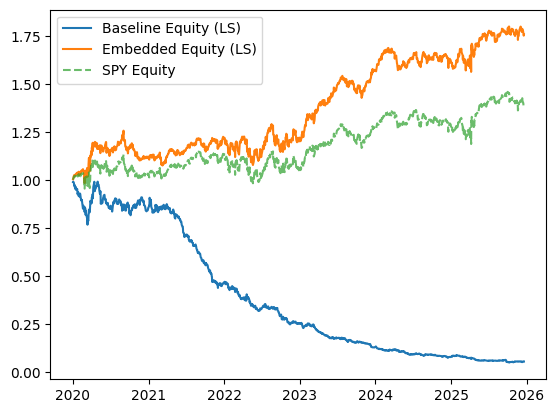

In [4]:
import matplotlib.pyplot as plt
plt.plot(out_ls["baseline"]["equity"], label="Baseline Equity (LS)")
plt.plot(out_ls["embedded"]["equity"], label="Embedded Equity (LS)")
plt.plot(out_ls["spy_eq"], label="SPY Equity", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


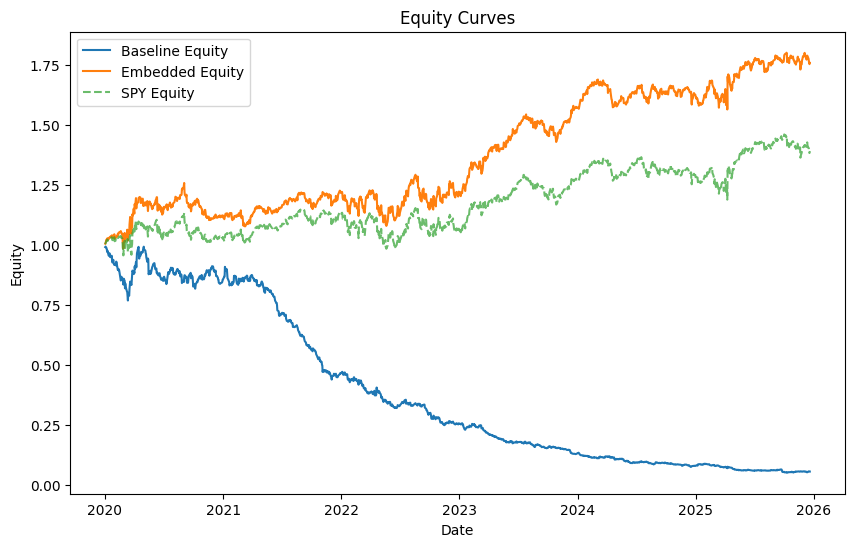

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(out_ls["baseline"]["equity"], label="Baseline Equity")
plt.plot(out_ls["embedded"]["equity"], label="Embedded Equity")
plt.plot(out_ls["spy_eq"], label="SPY Equity", linestyle="--", alpha=0.7)
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

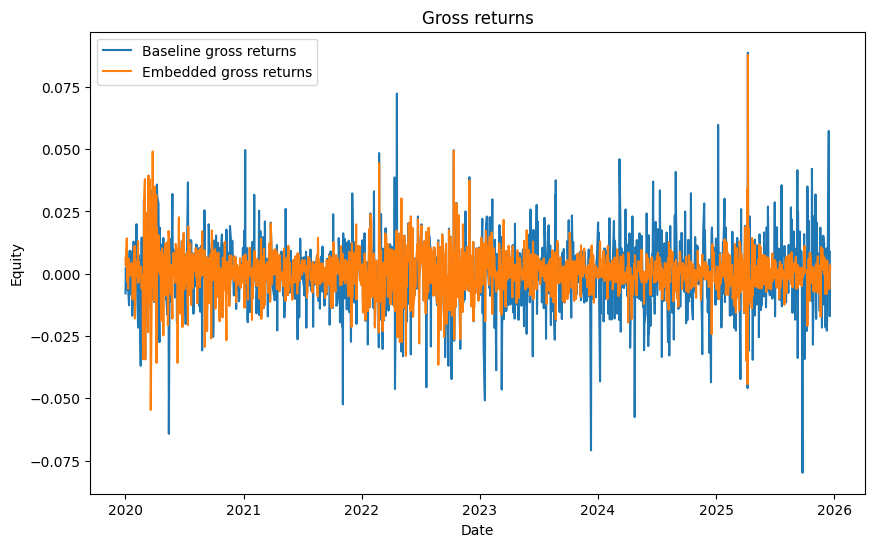

In [6]:
plt.figure(figsize=(10,6))
plt.plot(out_ls["baseline"]["gross"], label="Baseline gross returns")
plt.plot(out_ls["embedded"]["gross"], label="Embedded gross returns")
plt.legend()
plt.title("Gross returns")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

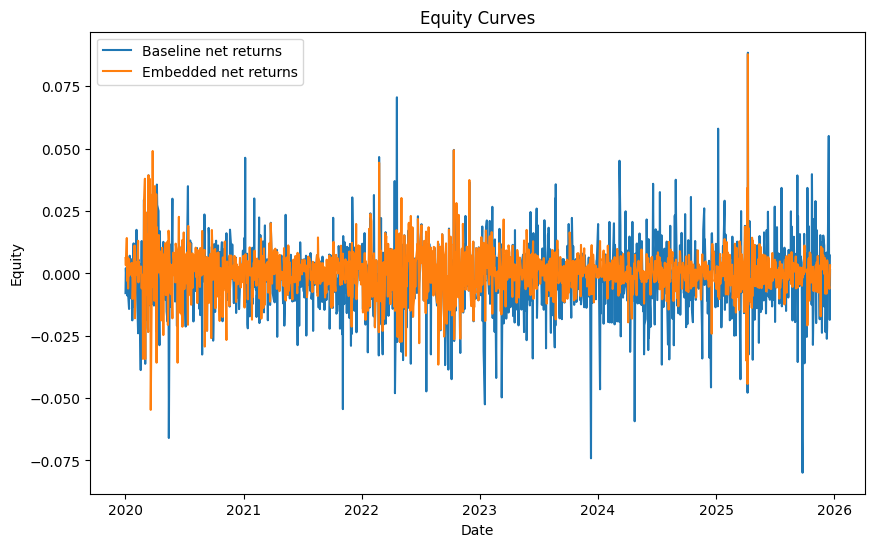

In [7]:
plt.figure(figsize=(10,6))
plt.plot(out_ls["baseline"]["net"], label="Baseline net returns")
plt.plot(out_ls["embedded"]["net"], label="Embedded net returns")
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

In [8]:
print("Baseline sharpe - gross returns:", perf_summary(out_ls["baseline"]["gross"])["Sharpe"])
print("Embedded sharpe - gross returns:", perf_summary(out_ls["embedded"]["gross"])["Sharpe"])

print("Baseline sharpe - net returns:", perf_summary(out_ls["baseline"]["net"])["Sharpe"])
print("Embedded sharpe - net returns:", perf_summary(out_ls["embedded"]["net"])["Sharpe"])

Baseline sharpe - gross returns: -0.04707453042850958
Embedded sharpe - gross returns: 0.7135242037036372
Baseline sharpe - net returns: -2.037131229138871
Embedded sharpe - net returns: 0.7078419989695124


In [9]:
print("Baseline maxDD - gross returns:", perf_summary(out_ls["baseline"]["gross"])["MaxDD"])
print("Embedded maxDD - gross returns:", perf_summary(out_ls["embedded"]["gross"])["MaxDD"])

print("Baseline maxDD - net returns:", perf_summary(out_ls["baseline"]["net"])["MaxDD"])
print("Embedded maxDD - net returns:", perf_summary(out_ls["embedded"]["net"])["MaxDD"])

Baseline maxDD - gross returns: -0.5742502720344249
Embedded maxDD - gross returns: -0.14299277022408718
Baseline maxDD - net returns: -0.9481747737000894
Embedded maxDD - net returns: -0.14338132655938263


In [10]:
perf_summary(out_ls["baseline"]["gross"])

{'CAGR': -0.03481007337305697,
 'Sharpe': -0.04707453042850958,
 'MaxDD': -0.5742502720344249,
 'AvgDailyTurnover': 1.0}

In [11]:
perf_summary(out_ls["embedded"]["gross"])

{'CAGR': 0.10050970087425948,
 'Sharpe': 0.7135242037036372,
 'MaxDD': -0.14299277022408718,
 'AvgDailyTurnover': 1.0}

In [12]:
perf_summary(out_ls["baseline"]["net"])

{'CAGR': -0.38309941655108704,
 'Sharpe': -2.037131229138871,
 'MaxDD': -0.9481747737000894,
 'AvgDailyTurnover': 1.0}

In [13]:
perf_summary(out_ls["embedded"]["net"])

{'CAGR': 0.09957293592510341,
 'Sharpe': 0.7078419989695124,
 'MaxDD': -0.14338132655938263,
 'AvgDailyTurnover': 1.0}

In [14]:
def alpha_beta(strat_rets, mkt_rets):
    x = mkt_rets.align(strat_rets, join="inner")[0].values
    y = strat_rets.align(mkt_rets, join="inner")[0].values
    X = np.column_stack([np.ones_like(x), x])
    # OLS
    b = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha, beta = b[0], b[1]
    # t-stat alpha
    resid = y - X @ b
    s2 = (resid @ resid) / (len(y) - 2)
    var_b = s2 * np.linalg.inv(X.T @ X)
    se_alpha = np.sqrt(var_b[0,0])
    t_alpha = alpha / (se_alpha + 1e-12)
    return alpha, beta, t_alpha

alpha_e, beta_e, t_e = alpha_beta(out_ls["embedded"]["net"], out_ls["spy_rets"])
alpha_b, beta_b, t_b = alpha_beta(out_ls["baseline"]["net"], out_ls["spy_rets"])

print("Embedded alpha/day, beta, t(alpha):", alpha_e, beta_e, t_e)
print("Baseline alpha/day, beta, t(alpha):", alpha_b, beta_b, t_b)
print("Embedded alpha/yr approx:", alpha_e * 252)


Embedded alpha/day, beta, t(alpha): 0.00016991859444298794 0.9418718893563308 2.5576387378394503
Baseline alpha/day, beta, t(alpha): -0.001885354943605899 0.2646655775028747 -5.246131058858092
Embedded alpha/yr approx: 0.04281948579963296


# Stress tests (Long-Short)

This section **does not change your existing workflow**. It assumes you already ran:

```python
out_ls = run_experiment(..., weight_mode="long_short", gross_long=..., gross_short=...)
```

and uses `out_ls` directly where possible.

We run 4 tests:
1. Cost + slippage sweep (fast, uses stored gross + turnover)
2. Feature ablation (retrain; slower)
3. Placebo: shuffle Y in training (retrain; should kill edge)
4. Monte Carlo (50k bootstrap paths on embedded net returns)


In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Helpers: metrics & recompute net under alternative cost assumptions
# ----------------------------

def perf_summary_with_turnover(bt_out, which="net", freq=252):
    'Compute CAGR/Sharpe/MaxDD, plus avg turnover and final equity.'
    r = bt_out[which].dropna()
    if len(r) < 10:
        return {}
    mu = r.mean()
    sd = r.std(ddof=0)
    sharpe = (mu / (sd + 1e-12)) * np.sqrt(freq)

    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = eq / peak - 1
    mdd = dd.min()

    cagr = eq.iloc[-1] ** (freq / len(r)) - 1

    avg_to = float(bt_out.get("turnover", pd.Series(index=r.index, data=np.nan)).reindex(r.index).mean())
    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd),
        "AvgTurnover": float(avg_to) if np.isfinite(avg_to) else np.nan,
        "FinalEquity": float(eq.iloc[-1]),
        "N": int(len(r)),
    }

def recompute_net_from_gross_and_turnover(bt_out, tc_bps_per_side, slip_bps):
    'Recompute net returns and equity for new costs WITHOUT rerunning the model.'
    gross = bt_out["gross"].copy()
    turnover = bt_out["turnover"].reindex(gross.index).fillna(0.0)

    cost_rate = (tc_bps_per_side + slip_bps) / 1e4
    net = gross - cost_rate * turnover
    eq = (1 + net.fillna(0)).cumprod()

    out = dict(bt_out)  # shallow copy
    out["net_recosted"] = net
    out["equity_recosted"] = eq
    return out

# Sanity: confirm out_ls exists
assert "out_ls" in globals(), "Run your main experiment first so out_ls exists."
print("Using universe size:", len(out_ls["universe"]))
print("Feature names:", out_ls["feat_names"])


Using universe size: 30
Feature names: ['mom20', 'mom60', 'mom252', 'rev5', 'vol20', 'prc_ma20', 'prc_ma60', 'volz20', 'rsi14']


,tc_bps_per_side,slip_bps,total_bps,baseline_sharpe,embedded_sharpe,baseline_cagr,embedded_cagr,baseline_maxdd,embedded_maxdd,baseline_final_eq,embedded_final_eq,avg_turnover_baseline,avg_turnover_embedded
0,5.0,2.0,7.0,-0.979450,0.710873,-0.216658,0.100072,-0.828699,-0.143174,2.335273e-01,1.764898,1.182033,0.002253
1,10.0,5.0,15.0,-2.037131,0.707842,-0.383099,0.099573,-0.948175,-0.143381,5.629222e-02,1.760130,1.182033,0.002253
2,20.0,10.0,30.0,-3.982367,0.702159,-0.606129,0.098637,-0.996238,-0.143770,3.888553e-03,1.751225,1.182033,0.002253
3,30.0,15.0,45.0,-5.855632,0.696476,-0.748796,0.097702,-0.999738,-0.144520,2.669022e-04,1.742364,1.182033,0.002253
4,60.0,30.0,90.0,-10.854705,0.679426,-0.935252,0.094901,-1.000000,-0.148051,8.303098e-08,1.716050,1.182033,0.002253


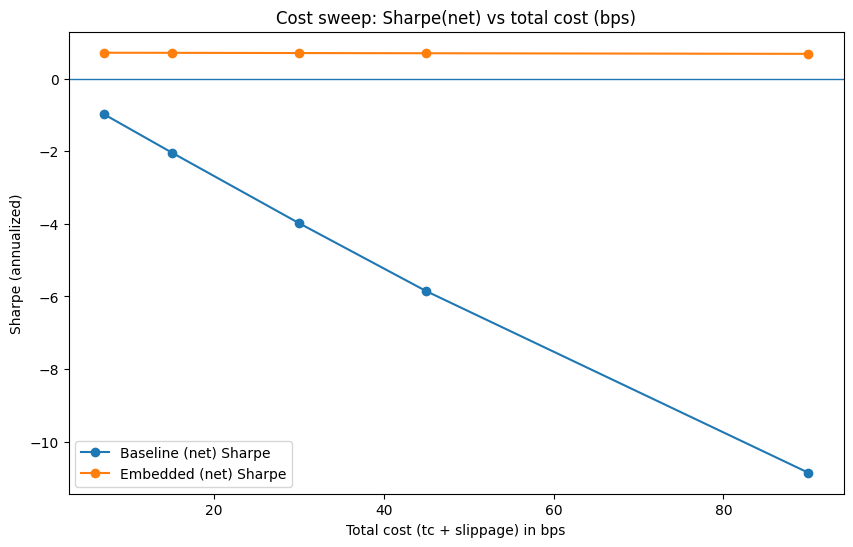

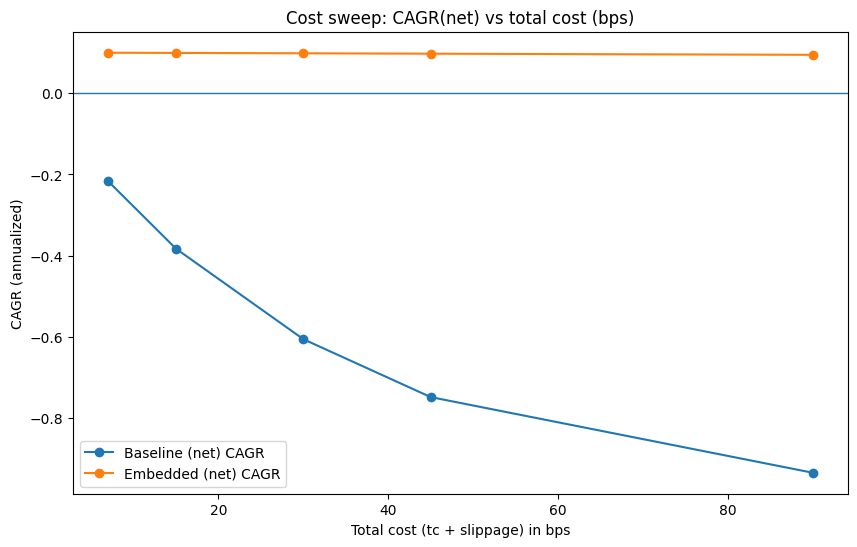

In [16]:

# ----------------------------
# 1) Cost + slippage sweep (FAST)
# ----------------------------

COST_GRID = [
    (5.0, 2.0),   # tc, slip (bps)
    (10.0, 5.0),
    (20.0, 10.0),
    (30.0, 15.0),
    (60.0, 30.0),
]

rows = []
for tc, slip in COST_GRID:
    base_rc = recompute_net_from_gross_and_turnover(out_ls["baseline"], tc, slip)
    emb_rc  = recompute_net_from_gross_and_turnover(out_ls["embedded"], tc, slip)

    s_base = perf_summary_with_turnover(base_rc, which="net_recosted")
    s_emb  = perf_summary_with_turnover(emb_rc,  which="net_recosted")

    rows.append({
        "tc_bps_per_side": tc,
        "slip_bps": slip,
        "total_bps": tc + slip,
        "baseline_sharpe": s_base.get("Sharpe", np.nan),
        "embedded_sharpe": s_emb.get("Sharpe", np.nan),
        "baseline_cagr": s_base.get("CAGR", np.nan),
        "embedded_cagr": s_emb.get("CAGR", np.nan),
        "baseline_maxdd": s_base.get("MaxDD", np.nan),
        "embedded_maxdd": s_emb.get("MaxDD", np.nan),
        "baseline_final_eq": s_base.get("FinalEquity", np.nan),
        "embedded_final_eq": s_emb.get("FinalEquity", np.nan),
        "avg_turnover_baseline": s_base.get("AvgTurnover", np.nan),
        "avg_turnover_embedded": s_emb.get("AvgTurnover", np.nan),
    })

cost_df = pd.DataFrame(rows).sort_values("total_bps")
display(cost_df)

# Plot: Sharpe vs total cost (two lines)
plt.figure(figsize=(10,6))
plt.plot(cost_df["total_bps"], cost_df["baseline_sharpe"], marker="o", label="Baseline (net) Sharpe")
plt.plot(cost_df["total_bps"], cost_df["embedded_sharpe"], marker="o", label="Embedded (net) Sharpe")
plt.axhline(0.0, linewidth=1)
plt.title("Cost sweep: Sharpe(net) vs total cost (bps)")
plt.xlabel("Total cost (tc + slippage) in bps")
plt.ylabel("Sharpe (annualized)")
plt.legend()
plt.show()

# Optional: CAGR vs cost
plt.figure(figsize=(10,6))
plt.plot(cost_df["total_bps"], cost_df["baseline_cagr"], marker="o", label="Baseline (net) CAGR")
plt.plot(cost_df["total_bps"], cost_df["embedded_cagr"], marker="o", label="Embedded (net) CAGR")
plt.axhline(0.0, linewidth=1)
plt.title("Cost sweep: CAGR(net) vs total cost (bps)")
plt.xlabel("Total cost (tc + slippage) in bps")
plt.ylabel("CAGR (annualized)")
plt.legend()
plt.show()


Epoch 01 | train pnl -0.000415 | train mse 0.003423 | val pnl +0.000121 | val mse 0.001263
Epoch 02 | train pnl +0.000185 | train mse 0.001035 | val pnl -0.000126 | val mse 0.000280
Epoch 03 | train pnl +0.000223 | train mse 0.000860 | val pnl +0.000121 | val mse 0.001436
Epoch 01 | train pnl +0.000011 | train mse 0.003888 | val pnl +0.000121 | val mse 0.007705
Epoch 02 | train pnl +0.000086 | train mse 0.001367 | val pnl -0.000121 | val mse 0.002490
Epoch 03 | train pnl +0.000112 | train mse 0.001136 | val pnl -0.000121 | val mse 0.000663
Epoch 01 | train pnl -0.000366 | train mse 0.004144 | val pnl +0.000383 | val mse 0.000276
Epoch 02 | train pnl -0.000013 | train mse 0.001283 | val pnl -0.000121 | val mse 0.000378
Epoch 03 | train pnl +0.000124 | train mse 0.000997 | val pnl +0.000121 | val mse 0.000960
Epoch 01 | train pnl +0.000175 | train mse 0.004390 | val pnl +0.000840 | val mse 0.000833
Epoch 02 | train pnl +0.000054 | train mse 0.001724 | val pnl -0.000101 | val mse 0.000260

,dropped_feature,CAGR,Sharpe,MaxDD,AvgTurnover,FinalEquity,N
8,volz20,0.101295,0.718083,-0.142712,0.000657,1.776617,1501
6,prc_ma20,0.101025,0.716303,-0.143165,0.000008,1.774025,1501
4,rev5,0.101015,0.716222,-0.143165,0.000000,1.773925,1501
5,vol20,0.101012,0.716208,-0.143165,0.000014,1.773899,1501
0,(none),0.100931,0.715761,-0.143165,0.000064,1.773117,1501
9,rsi14,0.100920,0.715649,-0.143133,0.000341,1.773011,1501
7,prc_ma60,0.100886,0.715461,-0.143233,0.000134,1.772683,1501
1,mom20,0.099420,0.706690,-0.143287,0.001894,1.758677,1501
2,mom60,-0.163678,-0.946666,-0.685963,0.212632,0.344850,1501
3,mom252,-0.216352,-1.051940,-0.803395,0.789745,0.234070,1501


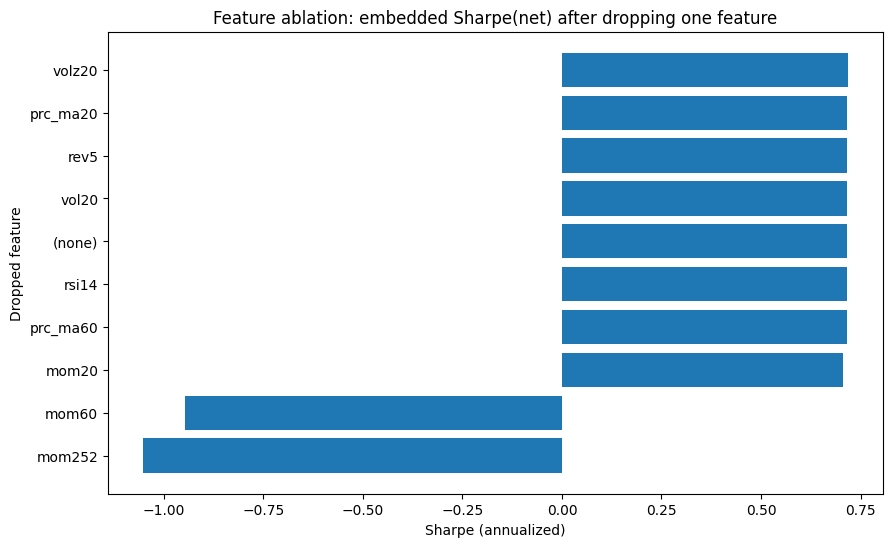

In [17]:

# ----------------------------
# 2) Feature ablation (RETRAIN; SLOWER)
# ----------------------------
# Idea: remove one feature at a time, retrain embedded model, test on the same splits.

ABL_EPOCHS = 3  # lower this to go faster

ABL_TICKERS = out_ls["universe"]
ABL_TOP_N = len(ABL_TICKERS)

def run_embedded_only_with_custom_feats(
    feats_override, y_override, *,
    tickers, seq_len=20,
    train_end="2017-12-31", val_end="2019-12-31",
    gamma=0.0, max_w=0.02,
    tc_bps=10.0, slip_bps=5.0,
    epochs=3, lr=1e-3, lam_embedded=0.8,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
):
    batches_all, feat_names = build_day_batches(feats_override, y_override, tickers=tickers, seq_len=seq_len)

    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)

    batches_train = [b for b in batches_all if pd.to_datetime(b[0]) <= train_end_dt]
    batches_val   = [b for b in batches_all if train_end_dt < pd.to_datetime(b[0]) <= val_end_dt]
    batches_test  = [b for b in batches_all if pd.to_datetime(b[0]) > val_end_dt]

    n_features = len(feat_names)

    model_emb = train_model(
        batches_train, batches_val, n_features,
        lam=lam_embedded, k_turn=0.05, k_conc=0.05,
        gamma=gamma, max_w=max_w,
        lr=lr, epochs=epochs,
        weight_mode=weight_mode, gross_long=gross_long, gross_short=gross_short,
    )

    bt_emb = backtest_batches(
        model_emb, batches_test,
        tc_bps_per_side=tc_bps, slip_bps=slip_bps,
        gamma=gamma, max_w=max_w,
        weight_mode=weight_mode, gross_long=gross_long, gross_short=gross_short
    )
    return bt_emb, feat_names

# Re-download data (yfinance variability warning). If you want perfect reproducibility, cache data locally.
data = download_ohlcv(list(dict.fromkeys(ABL_TICKERS + ["SPY"])), start="2010-01-01", end=None, auto_adjust=False)
feats_full, y_full = make_features(data)

feat_list = list(feats_full.keys())

results = []

# Full embedded model first
bt_full, _ = run_embedded_only_with_custom_feats(
    feats_full, y_full,
    tickers=ABL_TICKERS,
    epochs=ABL_EPOCHS,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
)
s_full = perf_summary_with_turnover(bt_full, which="net")
results.append({"dropped_feature": "(none)", **s_full})

# Drop one at a time
for drop in feat_list:
    feats_abl = {k:v for k,v in feats_full.items() if k != drop}
    bt_abl, _ = run_embedded_only_with_custom_feats(
        feats_abl, y_full,
        tickers=ABL_TICKERS,
        epochs=ABL_EPOCHS,
        weight_mode="long_short", gross_long=1.0, gross_short=1.0
    )
    s = perf_summary_with_turnover(bt_abl, which="net")
    results.append({"dropped_feature": drop, **s})

abl_df = pd.DataFrame(results).sort_values("Sharpe", ascending=False)
display(abl_df)

# Plot: Sharpe by ablation
plt.figure(figsize=(10,6))
tmp = abl_df.sort_values("Sharpe")
plt.barh(tmp["dropped_feature"], tmp["Sharpe"])
plt.title("Feature ablation: embedded Sharpe(net) after dropping one feature")
plt.xlabel("Sharpe (annualized)")
plt.ylabel("Dropped feature")
plt.show()


Training placebo baseline (MSE only) on shuffled labels...
Epoch 01 | train pnl +0.000024 | train mse 0.000700 | val pnl +0.000167 | val mse 0.000338
Epoch 02 | train pnl -0.000104 | train mse 0.000349 | val pnl +0.000186 | val mse 0.000613
Epoch 03 | train pnl +0.000169 | train mse 0.000305 | val pnl +0.000127 | val mse 0.000234

Training placebo embedded on shuffled labels...
Epoch 01 | train pnl +0.000081 | train mse 0.003096 | val pnl -0.000345 | val mse 0.000241
Epoch 02 | train pnl +0.000055 | train mse 0.001330 | val pnl +0.000121 | val mse 0.001865
Epoch 03 | train pnl +0.000218 | train mse 0.000816 | val pnl -0.000136 | val mse 0.000357

Placebo results (should be near 0 or negative after costs):
Baseline placebo: {'CAGR': -0.04207611142682055, 'Sharpe': -0.19247668858136566, 'MaxDD': -0.397930740133983, 'AvgTurnover': 0.22429683596593172, 'FinalEquity': 0.7741069010051052, 'N': 1501}
Embedded placebo: {'CAGR': 0.10101506234956403, 'Sharpe': 0.7162223514713034, 'MaxDD': -0.143

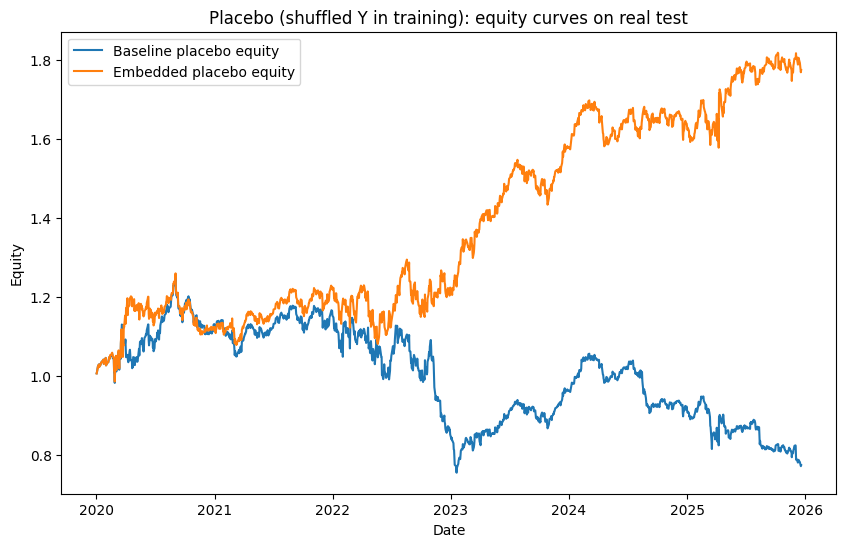

In [18]:

# ----------------------------
# 3) Placebo: shuffle Y in TRAINING (RETRAIN; should kill edge)
# ----------------------------
# Shuffle labels within each day across tickers for train+val only, then evaluate on real test.

PLACEBO_EPOCHS = 3
PLACEBO_TICKERS = out_ls["universe"]

data_p = download_ohlcv(list(dict.fromkeys(PLACEBO_TICKERS + ["SPY"])), start="2010-01-01", end=None, auto_adjust=False)
feats_p, y_p = make_features(data_p)

batches_all, feat_names = build_day_batches(feats_p, y_p, tickers=PLACEBO_TICKERS, seq_len=20)

train_end_dt = pd.to_datetime("2017-12-31")
val_end_dt = pd.to_datetime("2019-12-31")
batches_train = [b for b in batches_all if pd.to_datetime(b[0]) <= train_end_dt]
batches_val   = [b for b in batches_all if train_end_dt < pd.to_datetime(b[0]) <= val_end_dt]
batches_test  = [b for b in batches_all if pd.to_datetime(b[0]) > val_end_dt]

def shuffle_batch_Y(batches, seed):
    rng = np.random.default_rng(seed)
    out = []
    for (dt, X, Y) in batches:
        Y2 = Y.copy()
        rng.shuffle(Y2)  # permutes across tickers within the day
        out.append((dt, X, Y2))
    return out

batches_train_shuf = shuffle_batch_Y(batches_train, seed=1)
batches_val_shuf   = shuffle_batch_Y(batches_val,   seed=2)

n_features = len(feat_names)

print("Training placebo baseline (MSE only) on shuffled labels...")
model_base_p = train_model(
    batches_train_shuf, batches_val_shuf, n_features,
    lam=0.0, k_turn=0.0, k_conc=0.0,
    gamma=0.0, max_w=0.02,
    lr=1e-3, epochs=PLACEBO_EPOCHS,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
)

print("\nTraining placebo embedded on shuffled labels...")
model_emb_p = train_model(
    batches_train_shuf, batches_val_shuf, n_features,
    lam=0.8, k_turn=0.05, k_conc=0.05,
    gamma=0.0, max_w=0.02,
    lr=1e-3, epochs=PLACEBO_EPOCHS,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
)

bt_base_p = backtest_batches(
    model_base_p, batches_test,
    tc_bps_per_side=10.0, slip_bps=5.0,
    gamma=0.0, max_w=0.02,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
)
bt_emb_p = backtest_batches(
    model_emb_p, batches_test,
    tc_bps_per_side=10.0, slip_bps=5.0,
    gamma=0.0, max_w=0.02,
    weight_mode="long_short", gross_long=1.0, gross_short=1.0
)

print("\nPlacebo results (should be near 0 or negative after costs):")
print("Baseline placebo:", perf_summary_with_turnover(bt_base_p, "net"))
print("Embedded placebo:", perf_summary_with_turnover(bt_emb_p, "net"))

# Plot: placebo equity curves
plt.figure(figsize=(10,6))
plt.plot(bt_base_p["equity"], label="Baseline placebo equity")
plt.plot(bt_emb_p["equity"], label="Embedded placebo equity")
plt.title("Placebo (shuffled Y in training): equity curves on real test")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()


,value
CAGR_p01,-0.046224
CAGR_p05,-0.005551
CAGR_p25,0.055491
CAGR_p50,0.099690
CAGR_p75,0.145844
CAGR_p95,0.217133
CAGR_p99,0.268854
CAGR_mean,0.101876
CAGR_std,0.067587
Sharpe_p01,-0.245599


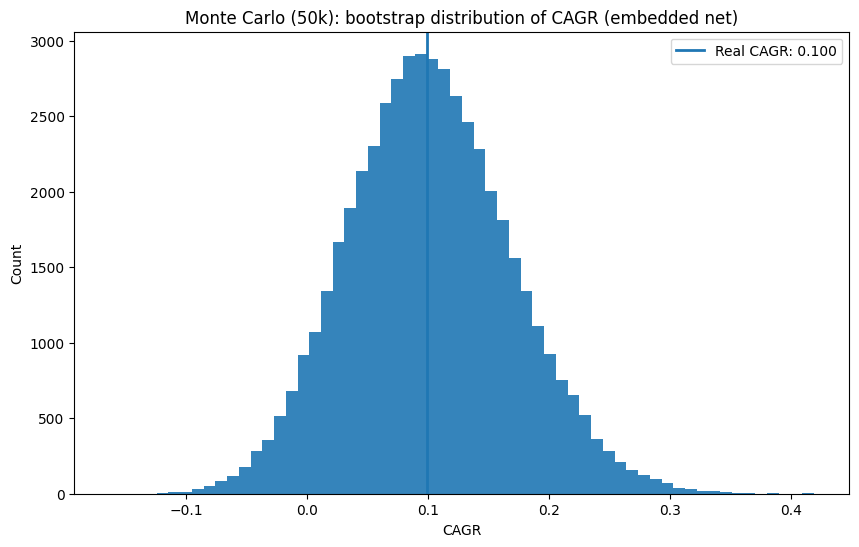

In [19]:

# ----------------------------
# 4) Monte Carlo bootstrap (50k sims) on embedded NET returns
# ----------------------------
# Resampling Monte Carlo on realized daily returns.
# Note: IID bootstrap is fast but ignores volatility clustering; block bootstrap is more realistic.

MC_SIMS = 50_000
CHUNK = 1000  # adjust for memory/speed

r = out_ls["embedded"]["net"].dropna().values.astype(np.float64)
T = len(r)
freq = 252

if T < 50:
    raise RuntimeError("Not enough returns for Monte Carlo.")

def mc_metrics_chunk(r, n_sims, rng):
    idx = rng.integers(0, len(r), size=(n_sims, len(r)))
    R = r[idx]  # [n_sims, T]

    mu = R.mean(axis=1)
    sd = R.std(axis=1, ddof=0)
    sharpe = (mu / (sd + 1e-12)) * np.sqrt(freq)

    EQ = np.cumprod(1.0 + R, axis=1)
    final_eq = EQ[:, -1]
    cagr = final_eq ** (freq / T) - 1.0

    peak = np.maximum.accumulate(EQ, axis=1)
    dd = EQ / (peak + 1e-12) - 1.0
    mdd = dd.min(axis=1)

    return sharpe, cagr, mdd

rng = np.random.default_rng(12345)
sharpes = np.empty(MC_SIMS, dtype=np.float64)
cagrs   = np.empty(MC_SIMS, dtype=np.float64)
mdds    = np.empty(MC_SIMS, dtype=np.float64)

pos = 0
while pos < MC_SIMS:
    n = min(CHUNK, MC_SIMS - pos)
    s, c, m = mc_metrics_chunk(r, n, rng)
    sharpes[pos:pos+n] = s
    cagrs[pos:pos+n]   = c
    mdds[pos:pos+n]    = m
    pos += n

def summarize_mc(arr, name):
    p = np.percentile(arr, [1, 5, 25, 50, 75, 95, 99])
    return {
        f"{name}_p01": p[0],
        f"{name}_p05": p[1],
        f"{name}_p25": p[2],
        f"{name}_p50": p[3],
        f"{name}_p75": p[4],
        f"{name}_p95": p[5],
        f"{name}_p99": p[6],
        f"{name}_mean": float(arr.mean()),
        f"{name}_std": float(arr.std(ddof=0)),
    }

mc_summary = {}
mc_summary.update(summarize_mc(cagrs, "CAGR"))
mc_summary.update(summarize_mc(sharpes, "Sharpe"))
mc_summary.update(summarize_mc(mdds, "MaxDD"))

mc_summary["P(CAGR<0)"] = float((cagrs < 0).mean())
mc_summary["P(Sharpe<0)"] = float((sharpes < 0).mean())
mc_summary["P(MaxDD<-0.3)"] = float((mdds < -0.3).mean())

display(pd.DataFrame([mc_summary]).T.rename(columns={0:"value"}))

# Plot: histogram of CAGR
plt.figure(figsize=(10,6))
plt.hist(cagrs, bins=60, alpha=0.9)
real_cagr = perf_summary_with_turnover(out_ls["embedded"], "net").get("CAGR", np.nan)
plt.axvline(real_cagr, linewidth=2, label=f"Real CAGR: {real_cagr:.3f}")
plt.title("Monte Carlo (50k): bootstrap distribution of CAGR (embedded net)")
plt.xlabel("CAGR")
plt.ylabel("Count")
plt.legend()
plt.show()
